# Análise e Visualização de Grafos


In [2]:
import pandas as pd
import matplotlib.pyplot as plt


class Graph:
    def __init__(self):
        self.vertices = [] 
        self.edges = []
        self.arcs = []

    def add_vertex(self, vertex):
        self.vertices.append(vertex)

    def add_edge(self, u, v, cost):
        self.edges.append(((u, v), cost))

    def add_arc(self, u, v, cost):
        self.arcs.append(((u, v), cost))


def read_file(path):
    try:
        with open(path, "r", encoding="utf-8") as arquivo:
            linhas = arquivo.readlines()
    except FileNotFoundError:
        print(f"Erro: Arquivo '{path}' não encontrado.")
        exit()
    except Exception as e:
        print(f"Erro ao ler o arquivo: {e}")
        exit()

    vertices = set()
    arestas = set()
    arcos = set()
    vertices_requeridos = set()
    arestas_requeridas = set()
    arcos_requeridos = set()
    secao_atual = None

    for linha in linhas:
        linha = linha.strip()

        # Ignora linhas vazias ou comentários
        if not linha or linha.startswith("//") or linha.startswith("Name:"):
            continue

        # Define a seção atual baseada no prefixo
        if linha.startswith("ReN."):
            secao_atual = "ReN"
            continue
        elif linha.startswith("ReE."):
            secao_atual = "ReE"
            continue
        elif linha.startswith("EDGE"):
            secao_atual = "EDGE"
            continue
        elif linha.startswith("ReA."):
            secao_atual = "ReA"
            continue
        elif linha.startswith("ARC"):
            secao_atual = "ARC"
            continue

        if linha and secao_atual:
            partes = linha.split("\t")
            try:
                if secao_atual == "ReN":
                    # Processa vértices obrigatórios
                    vertice = int(partes[0].replace("N", ""))
                    demanda = int(partes[1])
                    custo_servico = int(partes[2])
                    vertices_requeridos.add((vertice, (demanda, custo_servico)))
                    vertices.add(vertice)

                elif secao_atual in ["ReE", "EDGE"]:
                    # Processa arestas
                    origem, destino = int(partes[1]), int(partes[2])
                    vertices.update([origem, destino])
                    aresta = (min(origem, destino), max(origem, destino))
                    custo_transporte = int(partes[3])
                    arestas.add((aresta, custo_transporte))

                if secao_atual == "ReE":
                    # Processa arestas obrigatórias
                    demanda = int(partes[4])
                    custo_servico = int(partes[5])
                    arestas_requeridas.add((aresta, (custo_transporte, demanda, custo_servico)))

                elif secao_atual in ["ReA", "ARC"]:
                    # Processa arcos
                    origem, destino = int(partes[1]), int(partes[2])
                    vertices.update([origem, destino])
                    arco = (origem, destino)
                    custo_transporte = int(partes[3])
                    arcos.add((arco, custo_transporte))

                    if secao_atual == "ReA":
                        # Processa arcos obrigatórios
                        demanda = int(partes[4])
                        custo_servico = int(partes[5])
                        arcos_requeridos.add((arco, (custo_transporte, demanda, custo_servico)))
            except (ValueError, IndexError):
                
                continue

    if not vertices:
        print("Erro: Nenhum vértice encontrado no arquivo.")
        exit()

    return vertices, arestas, arcos, vertices_requeridos, arestas_requeridas, arcos_requeridos


def visualizar_grafo(vertices, edges, arcs, required_vertices, required_edges, required_arcs):
    """Exibe no console os elementos do grafo e os obrigatórios."""
    print("Visualização do Grafo:")
    print("Vértices:", vertices)
    print("Arestas:", edges)
    print("Arcos:", arcs)
    print("Vértices obrigatórios:", required_vertices)
    print("Arestas obrigatórias:", required_edges)
    print("Arcos obrigatórios:", required_arcs)


def quantidade_vertices(grafo):
    """Retorna a quantidade de vértices presentes no grafo (dicionário de adjacências)."""
    return len(grafo)


def quantidade_arestas(grafo):
    """Calcula o número de arestas (considerando grafo não direcionado)."""
    return sum(len(vizinhos) for vizinhos in grafo.values()) // 2


def imprimir_graus(graus):
    """Exibe o grau máximo e o grau mínimo dos vértices."""
    grau_maximo = max(sum(g[1]) for g in graus)
    grau_minimo = min(sum(g[1]) for g in graus)
    print("Grau máximo:", grau_maximo)
    print("Grau mínimo:", grau_minimo)


def quantidade_arcos(grafo):
    """Calcula a quantidade de arcos presentes no grafo (considera somente direção única se existir retorno)."""
    contagem = 0
    for u in grafo:
        for v in grafo[u]:
            if u in grafo.get(v, []):
                contagem += 1
    return contagem // 2


def floyd_warshall(vertices, edges, arcs):
    """Implementa o algoritmo de Floyd-Warshall para calcular a matriz de distâncias e predecessores."""
    dist = {v: {u: float('inf') for u in vertices} for v in vertices}
    pred = {v: {u: None for u in vertices} for v in vertices}

    for v in vertices:
        dist[v][v] = 0

    # Processa arestas (grafo não direcionado)
    for (u, v), cost in edges:
        dist[u][v] = cost
        dist[v][u] = cost
        pred[u][v] = u
        pred[v][u] = v

    # Processa arcos (direcionados)
    for (u, v), cost in arcs:
        dist[u][v] = cost
        pred[u][v] = u

    for k in vertices:
        for i in vertices:
            for j in vertices:
                if dist[i][k] + dist[k][j] < dist[i][j]:
                    dist[i][j] = dist[i][k] + dist[k][j]
                    pred[i][j] = pred[k][j]

    return dist, pred


def caminho_medio(vertices, edges, arcs):
    """Calcula o caminho médio entre todos os pares de vértices utilizando o algoritmo de Floyd-Warshall."""
    dist, _ = floyd_warshall(vertices, edges, arcs)
    soma = 0
    total_pares = 0

    for u in dist:
        for v in dist[u]:
            if u != v and dist[u][v] != float('inf'):
                soma += dist[u][v]
                total_pares += 1

    return soma / total_pares if total_pares > 0 else 0


def calc_densidade(num_arestas, num_arcos, num_vertices):
    """Calcula a densidade do grafo com base no número máximo de arestas e arcos possíveis."""
    edges_max = num_vertices * (num_vertices - 1) / 2
    arcs_max = num_vertices * (num_vertices - 1)
    densidade = (num_arestas + num_arcos) / (edges_max + arcs_max)
    return densidade


def calc_diametro(matriz_distancias):
    """Calcula o diâmetro do grafo com base na matriz de distâncias."""
    diametro = 0
    for origem in matriz_distancias:
        for destino in matriz_distancias[origem]:
            d = matriz_distancias[origem][destino]
            if d != float('inf') and origem != destino:
                diametro = max(diametro, d)
    return diametro


def criar_matriz_predecessores(vertices, arestas, arcos):
    """Retorna a matriz de predecessores a partir do algoritmo de Floyd-Warshall."""
    _, predecessores = floyd_warshall(vertices, arestas, arcos)
    return predecessores


def caminho_minimo(matriz_pred, origem, destino):
    """Recupera o caminho mínimo entre dois vértices usando a matriz de predecessores."""
    caminho = []
    if matriz_pred[origem][destino] is None:
        return caminho
    
    # Reconstrução do caminho
    atual = destino
    while atual != origem:
        caminho.insert(0, atual)
        atual = matriz_pred[origem][atual]
        if atual is None:
            return []
    caminho.insert(0, origem)
    return caminho


def calc_intermediacao(vertices, matriz_pred):
    """Calcula o índice de intermediação para cada vértice com base em todos os caminhos mínimos."""
    intermediacao = {v: 0 for v in vertices}

    for origem in vertices:
        for destino in vertices:
            if origem != destino:
                caminho = caminho_minimo(matriz_pred, origem, destino)
                if len(caminho) > 1:
                    for v in caminho[1:-1]:
                        intermediacao[v] += 1
    return intermediacao


def calcular_graus(vertices, arestas, arcos):
    """Calcula o grau total, o grau de entrada e o grau de saída para cada vértice."""
    graus = {v: [0, 0, 0] for v in vertices}  # [grau, entrada, saída]

    for (u, v), _ in arestas:
        graus[u][0] += 1
        graus[v][0] += 1

    for (u, v), _ in arcos:
        graus[u][2] += 1  # saída
        graus[v][1] += 1  # entrada

    return tuple((v, tuple(g)) for v, g in graus.items())


## Funções para Visualização Gráfica

As duas funções a seguir se encarregam de gerar os gráficos dos graus totais e da intermediação dos vértices.

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_grau_total(vertices, edges, arcs):
    """Plota um gráfico de barras com o grau total dos vértices."""
    # Calcula os graus dos vértices
    graus = calcular_graus(vertices, edges, arcs)
    grau_total = {v: sum(g) for v, g in graus}

    # Organiza os dados em um DataFrame
    df_graus = pd.DataFrame(list(grau_total.items()), columns=["Vértice", "Grau Total"])
    df_graus = df_graus.sort_values("Vértice")

    # Plota o gráfico de barras
    plt.figure(figsize=(10, 6))
    plt.bar(df_graus["Vértice"].astype(str), df_graus["Grau Total"], color="skyblue")
    plt.title("Grau Total dos Vértices")
    plt.xlabel("Vértice")
    plt.ylabel("Grau Total")
    plt.grid(True, axis="y", linestyle="--", alpha=0.7)
    plt.show()


import pandas as pd
import matplotlib.pyplot as plt

def plot_grau_total(vertices, edges, arcs):
    """Plota um gráfico de barras com o grau total dos vértices."""
    # Calcula os graus dos vértices
    graus = calcular_graus(vertices, edges, arcs)
    grau_total = {v: sum(g) for v, g in graus}

    # Organiza os dados em um DataFrame
    df_graus = pd.DataFrame(list(grau_total.items()), columns=["Vértice", "Grau Total"])
    df_graus = df_graus.sort_values("Vértice")

    # Plota o gráfico de barras
    plt.figure(figsize=(10, 6))
    plt.bar(df_graus["Vértice"].astype(str), df_graus["Grau Total"], color="skyblue")
    plt.title("Grau Total dos Vértices")
    plt.xlabel("Vértice")
    plt.ylabel("Grau Total")
    plt.grid(True, axis="y", linestyle="--", alpha=0.7)
    plt.show()


def plot_intermediacao(vertices, edges, arcs):
    intermediacao = calc_intermediacao(vertices, criar_matriz_predecessores(vertices, edges, arcs))

    df_intermediacao = pd.DataFrame(list(intermediacao.items()), columns=["Vértice", "Intermediação"])
    df_intermediacao = df_intermediacao.sort_values("Vértice")  # Ordena os vértices em ordem crescente

    # Plota o gráfico de barras
    plt.figure(figsize=(10, 6))
    plt.bar(df_intermediacao["Vértice"].astype(str), df_intermediacao["Intermediação"], color="orange")
    plt.title("Intermediação dos Vértices")
    plt.xlabel("Vértice")
    plt.ylabel("Intermediação")
    plt.grid(True, axis="y", linestyle="--", alpha=0.7)
    plt.show()

    print("Intermediação dos Vértice :")
    print(df_intermediacao.to_string(index=False))


def display_metrics(vertices, edges, arcs, densidade, diametro, caminho_medio, graus, intermediacao):
    df_graus = pd.DataFrame([(v, g[0], g[1], g[2], sum(g)) for v, g in graus],
                            columns=["Vértice", "Grau", "Entrada", "Saída", "Grau Total"])

    # DataFrame da intermediação
    df_intermediacao = pd.DataFrame(intermediacao.items(), columns=["Vértice", "Intermediação"])

    df_metrica = pd.DataFrame({
        "Métrica": ["Total Vértices", "Total Arestas", "Total Arcos", "Densidade", "Diâmetro", "Caminho Médio"],
        "Valor": [len(vertices), len(edges), len(arcs), densidade, diametro, caminho_medio]
    })

    # Exibe os DataFrames
    display(df_graus.sort_values("Vértice"))
    display(df_intermediacao.sort_values("Intermediação", ascending=False))
    display(df_metrica)


def display_metrics(vertices, edges, arcs, densidade, diametro, caminho_medio, graus, intermediacao):
    df_graus = pd.DataFrame([(v, g[0], g[1], g[2], sum(g)) for v, g in graus],
                            columns=["Vértice", "Grau", "Entrada", "Saída", "Grau Total"])


    df_intermediacao = pd.DataFrame(intermediacao.items(), columns=["Vértice", "Intermediação"])
    
    df_metrica = pd.DataFrame({
        "Métrica": ["Total Vértices", "Total Arestas", "Total Arcos", "Densidade", "Diâmetro", "Caminho Médio"],
        "Valor": [len(vertices), len(edges), len(arcs), densidade, diametro, caminho_medio]
    })

    # Exibe os DataFrames
    display(df_graus.sort_values("Vértice"))
    display(df_intermediacao.sort_values("Intermediação", ascending=False))
    display(df_metrica)

## Execução Principal

Execute aqui caso queria visualizar como o programa funciona

Quantidade de vértices: 12
Quantidade de arestas: 11
Quantidade de arcos: 22
Caminho médio: 16.71
Densidade do grafo: 0.17
Diâmetro do grafo: 30
Visualização do Grafo:
Vértices: {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12}
Arestas: {((7, 12), 18), ((5, 12), 11), ((8, 11), 10), ((2, 9), 2), ((2, 3), 18), ((7, 8), 8), ((10, 11), 12), ((9, 10), 16), ((5, 11), 20), ((2, 4), 9), ((5, 6), 7)}
Arcos: {((4, 3), 20), ((9, 11), 14), ((6, 12), 3), ((10, 1), 19), ((5, 3), 5), ((1, 4), 17), ((6, 7), 4), ((2, 1), 13), ((11, 9), 14), ((8, 10), 3), ((1, 2), 13), ((12, 1), 4), ((1, 10), 19), ((10, 8), 3), ((3, 4), 20), ((7, 1), 19), ((7, 6), 4), ((12, 6), 3), ((1, 12), 4), ((4, 1), 17), ((3, 5), 5), ((1, 7), 19)}
Vértices obrigatórios: {(3, (1, 1)), (10, (1, 1)), (4, (1, 1)), (11, (1, 1)), (12, (1, 1)), (7, (1, 1)), (2, (1, 1))}
Arestas obrigatórias: {((7, 12), (18, 1, 19)), ((5, 6), (7, 1, 8)), ((2, 3), (18, 1, 19)), ((9, 10), (16, 1, 17)), ((10, 11), (12, 1, 13)), ((5, 12), (11, 1, 12)), ((5, 11), (20, 1,

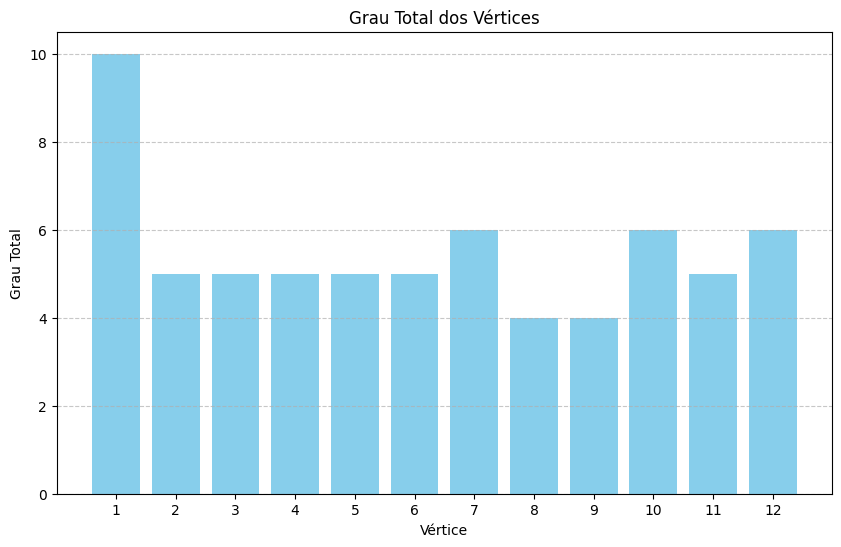

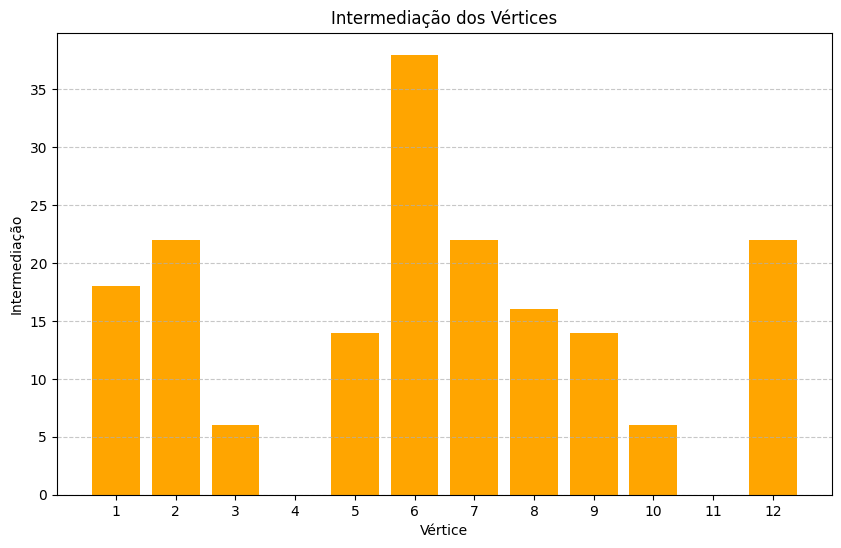

Intermediação dos Vértice :
 Vértice  Intermediação
       1             18
       2             22
       3              6
       4              0
       5             14
       6             38
       7             22
       8             16
       9             14
      10              6
      11              0
      12             22


In [4]:
def main():
    nome_arquivo = input("Digite o nome do arquivo/caminho: ").strip()

    resultado = read_file(nome_arquivo)

    if resultado is None:
        print("Erro ao carregar o grafo")
        exit()

    vertices, edges, arcs, required_vertices, required_edges, required_arcs = resultado

    if not vertices:
        print("Erro: Grafo vazio.")
        exit()

    grafo = {v: [] for v in vertices}

    for (u, v), _ in edges:
        grafo[u].append(v)
        grafo[v].append(u)

    for (u, v), _ in arcs:
        grafo[u].append(v)

    print("Quantidade de vértices:", quantidade_vertices(grafo))
    print("Quantidade de arestas:", len(edges))
    print("Quantidade de arcos:", quantidade_arcos(grafo))
    print("Caminho médio:", round(caminho_medio(vertices, edges, arcs), 2))
    print("Densidade do grafo:", round(calc_densidade(len(edges), len(arcs), len(vertices)), 2))

    matriz_distancias, _ = floyd_warshall(vertices, edges, arcs)
    print("Diâmetro do grafo:", calc_diametro(matriz_distancias))

    # Visualizações do grafo
    visualizar_grafo(vertices, edges, arcs, required_vertices, required_edges, required_arcs)

    # Plot do grau total
    plot_grau_total(vertices, edges, arcs)

    # Plot da intermediação
    plot_intermediacao(vertices, edges, arcs)

if __name__ == "__main__":
    main()
